In [3]:
import random
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [4]:
def read_test_file(filename): #ucitavanje test fajlova
    with open(filename, 'r') as file:
        n = int(file.readline().strip())
        num_stations = n + 1

        d = []
        for _ in range(num_stations):
            d.append(list(map(int, file.readline().strip().split())))

        t = []
        for _ in range(n):
            t.append(list(map(int, file.readline().strip().split())))

    d = np.array(d)
    d.reshape(n+1, n+1)
    t = np.array(t)
    t.reshape(n, n)
    return n, d, t

uploaded = files.upload()
filename = list(uploaded.keys())[0]
n, d, t = read_test_file(filename)

#ispis tabele
d_df = pd.DataFrame(d, columns=[f"Stanica {i}" for i in range(n+1)], index=[f"Stanica {i}" for i in range(n+1)])
t_df = pd.DataFrame(t, columns=[f"Posao {j+1}" for j in range(n)], index=[f"Stanica {i+1}" for i in range(n)])

print(f"Broj poslova (n): {n}\n")
print("Distance (d):")
print(d_df)
print("\nVremena (t):")
print(t_df)

Saving eil101.in to eil101.in
Broj poslova (n): 100

Distance (d):
             Stanica 0  Stanica 1  Stanica 2  Stanica 3  Stanica 4  Stanica 5  \
Stanica 0            0         33         15         32         32         25   
Stanica 1           33          0         34         20         24         16   
Stanica 2           15         34          0         25         43         34   
Stanica 3           32         20         25          0         41         32   
Stanica 4           32         24         43         41          0         10   
...                ...        ...        ...        ...        ...        ...   
Stanica 96          32         11         38         30         13          9   
Stanica 97          36         16         43         36         10         11   
Stanica 98          31         17         40         36          6          6   
Stanica 99          39         17         46         37         12         14   
Stanica 100         15         18         

In [5]:
#Pomocne funkcije

def inicijalizuj_populaciju(n, pop_vel):
    broj_stanica = n+1
    populacija = []
    for _ in range(pop_vel):
        obilazak = list(range(broj_stanica))
        shuffled_obilazak = obilazak[1:]
        random.shuffle(shuffled_obilazak)
        obilazak[1:] = shuffled_obilazak
        poslovi = list(range(n))
        random.shuffle(poslovi)
        populacija.append((obilazak, poslovi))
    return populacija

def rulet(hromozomi, troskovi): #ruletska selekcija sa rangovima
    # sortira hromozome
    s_indeksi = np.argsort(troskovi)
    s_indeksi = s_indeksi[::-1]
    s_hromozomi = [hromozomi[i] for i in s_indeksi]

    # rangiranje jedinki i racunanje verovatnoca
    rangovi = np.arange(1, len(hromozomi) + 1)
    total = np.sum(rangovi)
    verovatnoce = rangovi / total

    # selekcija roditelja
    indeks1, indeks2 = np.random.choice(len(s_hromozomi), size=2, replace=False, p=verovatnoce)
    r_hromozom1 = s_hromozomi[indeks1]
    r_hromozom2 = s_hromozomi[indeks2]

    return r_hromozom1, r_hromozom2

def rand(hromozomi):
  return random.sample(hromozomi, 2)

def izracunaj_vreme(obilazak, poslovi, d, t): #vraca niz vremena zavrsetka poslova
    vremena_zavrsetka = []
    cml_vremena_puta = [0] * len(obilazak)

    for i in range(1, len(obilazak)):
        cml_vremena_puta[i] = cml_vremena_puta[i - 1] + d[obilazak[i - 1]][obilazak[i]]

    for i, stanica in enumerate(obilazak[1:], 1):  # Preskacem nultu stanicu
        posao = poslovi[i-1]
        vreme_puta = cml_vremena_puta[i]
        vreme_posla = t[stanica-1][posao-1]
        vreme_zavrsetka = vreme_puta + vreme_posla
        vremena_zavrsetka.append(vreme_zavrsetka)

    vreme_povratka = cml_vremena_puta[-1] + d[obilazak[-1]][0]
    vremena_zavrsetka.append(vreme_povratka)
    return vremena_zavrsetka

def trosak(resenje, d, t):
    obilazak, poslovi = resenje
    vremena_zavrsetka = izracunaj_vreme(obilazak, poslovi, d, t)
    return max(vremena_zavrsetka)


def pom_ox(inb, duzina, a, nova_a): #pomocna
  index = (inb + 1) % duzina
  for i in range(inb + 1, duzina + inb + 1):
    if a[i % duzina] not in nova_a:
      nova_a[index] = a[i % duzina]
      index += 1
      if index >= duzina:
        index -= duzina

def ox_ukrstanje(a, b, duzina): # a i b - ulazni obilazak/poslovi , duzina=broj poslova/stanica
  ina, inb = random.randint(0, duzina - 1), random.randint(0, duzina - 1)
  while ina == inb:
    inb = random.randint(0, duzina - 1)
  if ina > inb:
    ina, inb = inb, ina
  nova_a = [None] * duzina
  nova_b = [None] * duzina
  for i in range(ina, inb + 1):
    nova_a[i] = b[i]
    nova_b[i] = a[i]
  pom_ox(inb, duzina, a, nova_a)
  pom_ox(inb, duzina, b, nova_b)
  return nova_a, nova_b

def ukrsti(h1, h2, n): #ukrsta ox ukrstanjem posebno obilaske posebno poslove
  dete1_obilazak, dete2_obilazak = ox_ukrstanje(h1[0][1:], h2[0][1:], n)
  dete1_obilazak.insert(0,0)
  dete2_obilazak.insert(0,0)

  dete1_poslovi, dete2_poslovi = ox_ukrstanje(h1[1], h2[1], n)

  dete1=(dete1_obilazak, dete1_poslovi)
  dete2=(dete2_obilazak, dete2_poslovi)

  return dete1, dete2

def mutiraj_pom(x, n):
  ina, inb = random.randint(0, n - 1), random.randint(0, n - 1)
  while ina == inb:
    inb = random.randint(0, n - 1)
  x[ina], x[inb] = x[inb], x[ina]
  return x

def mutiraj(h, n, mut_rate):
  novi_obilazak = h[0]
  novi_poslovi = h[1]

  if random.random() < mut_rate:
      novi_obilazak = mutiraj_pom(h[0][1:], n)
      novi_obilazak.insert(0,0)

  if random.random() < mut_rate:
      novi_poslovi = mutiraj_pom(h[1], n)

  return (novi_obilazak, novi_poslovi)

def imigranti(n, d, t, populacija, broj_imigranata):
  imigranti = inicijalizuj_populaciju(n, broj_imigranata)
  populacija[-broj_imigranata:] = imigranti
  populacija = sorted(populacija, key=lambda x:trosak(x, d, t))

  return populacija

In [6]:
#Genetski algoritam

def genetski(n, d, t):
    broj_stanica = n + 1
    pop_vel = 20
    br_generacija = 10000
    mut_rate = 0.2

    #priprema za plotovanje
    fig, axs = plt.subplots(2)
    fig.set_size_inches(10, 6)
    axs[0].set_xlabel('Redni broj generacije')
    axs[0].set_ylabel('Trošak najboljeg rešenja')
    axs[1].set_xlabel('Redni broj generacije')
    axs[1].set_ylabel('Prosečan trošak generacije')

    populacija = inicijalizuj_populaciju(n, pop_vel)
    goat = populacija[0]
    niz_najboljih = []
    pr_troskovi = []

    for generacija in range(br_generacija):

        # if generacija%30 == 0:
        #     populacija = imigranti(n, d, t, populacija, 1)

        for i in range(0, pop_vel, 2):
            troskovi = [trosak(hromozom, d, t) for hromozom in populacija]
            # roditelj1, roditelj2 = rulet(populacija, troskovi)
            roditelj1, roditelj2 = rand(populacija)
            dete1, dete2 = ukrsti(roditelj1, roditelj2, n)
            populacija.append(mutiraj(dete1, n, mut_rate))
            populacija.append(mutiraj(dete2, n, mut_rate))

        populacija = sorted(populacija, key=lambda x:trosak(x, d, t)) #sortiramo po trosku
        tr_najbolji = populacija[0]

        niz_najboljih.append(trosak(tr_najbolji, d, t))
        troskovi_generacije = [trosak(hromozom, d, t) for hromozom in populacija]
        prosecni_trosak = np.mean(troskovi_generacije)
        pr_troskovi.append(prosecni_trosak)

        if(trosak(tr_najbolji, d, t) < trosak(goat, d, t)):
          goat = tr_najbolji
          min_trosak = trosak(goat, d, t)

        populacija = populacija[:pop_vel] #odsecanje

        if generacija%200 == 0:
          print('#', generacija, ': ', tr_najbolji, ' -> ', trosak(tr_najbolji, d, t)) #trenutno najbolji u svakoj iteraciji

    axs[0].plot(np.arange(1, br_generacija+1), niz_najboljih)
    axs[1].plot(np.arange(1, br_generacija+1), pr_troskovi)

    return goat, min_trosak

# 0 :  ([0, 95, 27, 46, 29, 65, 80, 30, 20, 61, 25, 17, 89, 62, 64, 76, 52, 91, 59, 39, 55, 8, 96, 42, 92, 82, 4, 87, 58, 12, 40, 53, 36, 88, 93, 90, 45, 51, 72, 5, 75, 85, 67, 26, 1, 77, 28, 78, 31, 84, 74, 57, 35, 97, 10, 2, 49, 19, 81, 11, 50, 69, 56, 13, 54, 48, 63, 15, 43, 60, 66, 68, 3, 71, 47, 18, 73, 21, 34, 44, 14, 41, 32, 70, 33, 23, 94, 16, 86, 99, 6, 100, 83, 7, 79, 22, 98, 38, 37, 24, 9], [80, 46, 45, 98, 44, 67, 51, 7, 59, 86, 65, 5, 77, 43, 29, 33, 50, 69, 48, 37, 1, 18, 8, 34, 79, 73, 15, 71, 3, 19, 40, 20, 10, 31, 72, 96, 23, 16, 21, 97, 91, 85, 99, 27, 95, 41, 81, 12, 9, 66, 52, 54, 93, 58, 47, 82, 62, 55, 42, 32, 84, 38, 36, 24, 30, 60, 2, 68, 53, 39, 70, 75, 22, 87, 90, 78, 4, 25, 63, 17, 89, 35, 64, 13, 83, 28, 76, 56, 92, 14, 74, 0, 57, 94, 11, 88, 49, 61, 6, 26])  ->  3398
# 200 :  ([0, 76, 60, 35, 17, 51, 10, 46, 45, 98, 90, 37, 43, 14, 13, 36, 84, 97, 86, 54, 20, 88, 6, 87, 30, 18, 69, 80, 1, 15, 48, 63, 9, 68, 11, 25, 79, 33, 70, 32, 71, 77, 50, 2, 75, 100, 59

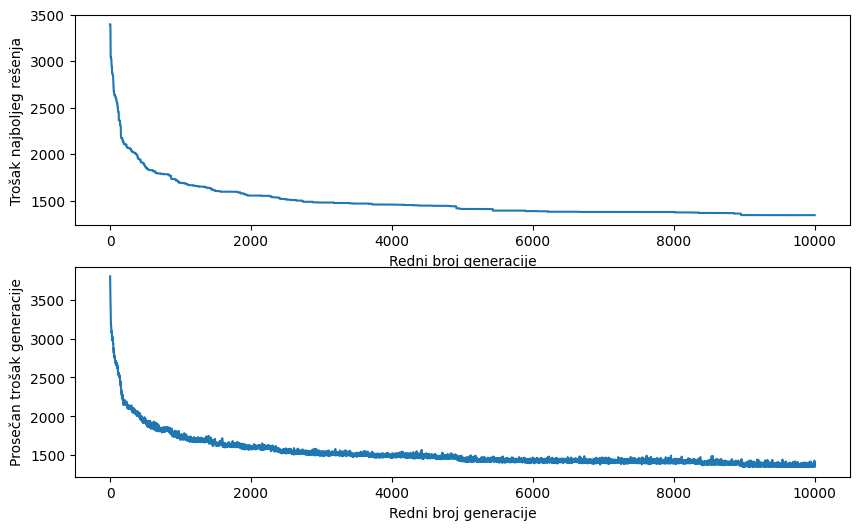

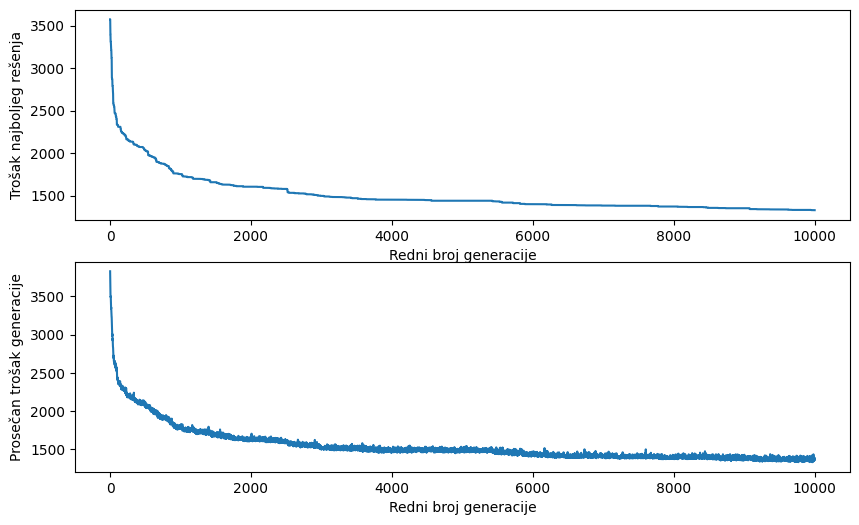

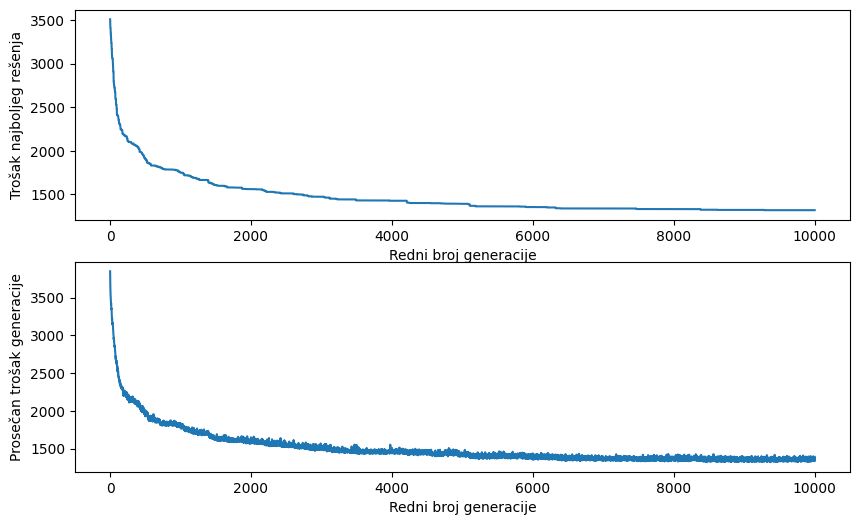

In [7]:
prosek = 0
for i in range(1,4):
    res, min_trosak = genetski(n, d, t)
    print(f"Konacno resenje: {res}")
    print(f"Trosak: {min_trosak}")
    prosek +=min_trosak

prosek /=3
print(f'Prosek: {prosek}')